<a href="https://colab.research.google.com/github/Tamaracarrasco/TamoJosha-Lab-de-Prog-MDS-Prim2025/blob/rama_lab_5/Copia%20de%20Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1) Quita versiones que chocan
!pip -q uninstall -y scikit-learn imbalanced-learn pandas numpy scipy matplotlib umap-learn xarray plotnine || true

# 2) Instala versiones compatibles con PyCaret 3.3.2 (CPU)
!pip -q install --no-deps scikit-learn==1.3.2 imbalanced-learn==0.11.0 numpy==1.26.4 pandas==2.1.4 scipy==1.11.4 matplotlib==3.7.5
!pip -q install pycaret==3.3.2 lightgbm==4.0.0 xgboost==1.7.6 catboost==1.2.5 umap-learn==0.5.5

# 3) Reinicia el runtime (necesario porque sklearn cambia binarios)
import IPython
IPython.display.clear_output()
print("✅ Entorno listo. Ahora ve a: Entorno de ejecución → Reiniciar entorno de ejecución, y luego ejecuta el Bloque 2.")


✅ Entorno listo. Ahora ve a: Entorno de ejecución → Reiniciar entorno de ejecución, y luego ejecuta el Bloque 2.


In [1]:
# Verifica versiones clave
import sklearn, imblearn, numpy, pandas, matplotlib
print("sklearn:", sklearn.__version__,
      "| imblearn:", imblearn.__version__,
      "| numpy:", numpy.__version__,
      "| pandas:", pandas.__version__,
      "| matplotlib:", matplotlib.__version__)

# Import mínimo de PyCaret clasificación
from pycaret.classification import setup, compare_models, pull, get_config
print("PyCaret OK")


sklearn: 1.4.2 | imblearn: 0.14.0 | numpy: 1.26.4 | pandas: 2.1.4 | matplotlib: 3.7.5
PyCaret OK


Este código corre y entra en la carpeta data cuando estoy en colab, si no es el caso entonces se salta al except e ignora la conexión y en teoría corre en VSCode u otra plataforma sin problema porque después lee el archivo.


## 1. Predicción de Seleccionados Nacionales

**1.1 Preprocesamiento**

Tenemos que montar la conexión con el drive para que colab pueda trabajar sobre el archivo.

In [2]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = '/content/drive/MyDrive/data/stats_players.csv'
except:
    print('Ignorando conexión drive-colab')

Mounted at /content/drive


Importamos las librerías importantes y necesarias para trabajar

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

Importamos la base de datos

In [4]:
data = pd.read_csv(path, sep=",")

Despliego algunos estadísticos de la base para empezar a entenderla

In [5]:
print("Dimensiones del dataset de los stats", data.shape)

print("Columnas del dataset de stats", data.columns.tolist())

print("Información de los valores de las columnas")
data.info()
data.head()

Dimensiones del dataset de los stats (17588, 39)
Columnas del dataset de stats ['Name', 'Nationality', 'National_Position', 'Club_Position', 'Height', 'Weight', 'Preffered_Foot', 'Age', 'Work_Rate', 'Weak_foot', 'Skill_Moves', 'Ball_Control', 'Dribbling', 'Marking', 'Sliding_Tackle', 'Standing_Tackle', 'Aggression', 'Reactions', 'Interceptions', 'Vision', 'Composure', 'Crossing', 'Short_Pass', 'Long_Pass', 'Acceleration', 'Speed', 'Stamina', 'Strength', 'Balance', 'Agility', 'Jumping', 'Heading', 'Shot_Power', 'Finishing', 'Long_Shots', 'Curve', 'Freekick_Accuracy', 'Penalties', 'Volleys']
Información de los valores de las columnas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17588 entries, 0 to 17587
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               17588 non-null  object
 1   Nationality        17588 non-null  object
 2   National_Position  1075 non-null   object
 3   Club_Positi

,Name,Nationality,National_Position,Club_Position,Height,Weight,Preffered_Foot,Age,Work_Rate,Weak_foot,...,Agility,Jumping,Heading,Shot_Power,Finishing,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys
0,Cristiano Ronaldo,Portugal,LS,LW,185,80,Right,32,High / Low,4,...,90,95,85,92,93,90,81,76,85,88
1,Lionel Messi,Argentina,RW,RW,170,72,Left,29,Medium / Medium,4,...,90,68,71,85,95,88,89,90,74,85
2,Neymar,Brazil,LW,LW,174,68,Right,25,High / Medium,5,...,96,61,62,78,89,77,79,84,81,83
3,Luis Suárez,Uruguay,LS,ST,182,85,Right,30,High / Medium,4,...,86,69,77,87,94,86,86,84,85,88
4,Manuel Neuer,Germany,GK,GK,193,92,Right,31,Medium / Medium,4,...,52,78,25,25,13,16,14,11,47,11


**Pregunta 1:** Genere los labels para la clasificación binaria en una variable llamada `label`. Para esto, trabaje sobre el atributo `National_Position` suponiendo que los valores nulos son jugadores no seleccionados para representar a su país.

Saco algunos estadísticos de la varibale "National_Position"

In [6]:
print("Conteo de valores de National_Position \n", data["National_Position"].value_counts(dropna=False))

print("\n Cantidad de valores únicos de National_Position: ", data["National_Position"].nunique())

Conteo de valores de National_Position 
 National_Position
NaN    16513
Sub      556
LCB       48
GK        47
RCB       46
LB        39
RB        38
RM        34
LM        32
ST        30
LCM       25
RCM       25
LDM       19
CAM       19
LS        18
RS        18
RDM       18
CB         9
CM         9
CDM        9
RW         7
LW         7
LWB        4
LAM        4
RWB        4
RAM        4
LF         3
RF         3
Name: count, dtype: int64

 Cantidad de valores únicos de National_Position:  27


Luego de lo anterior, entonces me dispongo a crear la variable "label", dicotómica, en donde 1 indicara jugadores que fueron seleccionados para jugar por su país y 0 que no fueron seleccionados. Esto, en base a la varibale de National_positions.

In [7]:
# Primero relleno los NaN de National_Position con la palabra "Vacío"

data["National_Position"] = data["National_Position"].fillna("Vacío")

# Aquí procedo a crear la variable "label" (0 y 1) en base a National_Position
# y considernado la modificació previa en la variable con "Vacío"

data.loc[data["National_Position"] == "Vacío", "label"] = 0
data.loc[data["National_Position"] != "Vacío", "label"] = 1

Aplico el value counts para poder comprobar que se asignaron correctamente considerando que previo a todo había aplicado esto para National_Position.


In [8]:
data["label"].value_counts()

,count
label,
0.0,16513
1.0,1075


**Pregunta 2:** Hecho esto, ¿cuántos se tienen ejemplos por cada clase? Comente lo que observa.




Luego de crear la variable "label", se observa que la clase 0 (jugadores no seleccionados) cuenta con 16.513 ejemplos (≈94 %), mientras que la clase 1 (jugadores seleccionados) tiene 1.075 ejemplos (≈6 %). Esto evidencia un desbalance de clases marcado, donde la clase positiva es claramente minoritaria. Este desbalance podría influir en el entrenamiento de futuros modelos, ya que un clasificador ingenuo que prediga siempre la clase mayoritaria obtendría alta exactitud, pero sin capacidad real de identificar jugadores seleccionados.

**Pregunta 3:** Genere un `ColumnTransformer` en donde especifique las transformaciones que hay que realizar para cada columna (por ejemplo StandarScaler, MinMaxScaler, OneHotEncoder, etc...) para que puedan ser utilizadas correctamente por el modelo predictivo y guárdelo una variable llamada `col_transformer`.

In [9]:
# Listar columnas
drop_cols = [
    "Name",
    "National_Position"
]

# 2. OHE (cardinalidad moderada)
ohe_nationality = ["Nationality"]

# 4. Club_Position: OHE + imputación (1 missing) -> NO se dropean filas
ohe_clubpos = ["Club_Position"]

# 7. Preferred_Foot: Dejamos explícitamente el orden ['Left','Right'] y drop='if_binary'
#    => la única columna resultante será el indicador de 'Right' (1 = Right).
ohe_binary_foot = ["Preffered_Foot"]

# 9. Work_Rate: OHE
ohe_workrate = ["Work_Rate"]

# 10–11. Ordinal (1..5)

ord_1to5 = ["Weak_foot", "Skill_Moves"]
cats_1to5 = [[1, 2, 3, 4, 5]] * len(ord_1to5)

# 5–6, 8, 12–39. Numéricas (StandardScaler)
num_std = [
    "Height", "Weight", "Age",
    "Ball_Control", "Dribbling", "Marking", "Sliding_Tackle", "Standing_Tackle",
    "Aggression", "Reactions", "Interceptions", "Vision",
    "Composure", "Crossing", "Short_Pass", "Long_Pass",
    "Acceleration", "Speed", "Stamina", "Strength", "Balance", "Agility",
    "Jumping", "Heading",
    "Shot_Power", "Finishing", "Long_Shots", "Curve",
    "Freekick_Accuracy", "Penalties", "Volleys"
]

# PIPELINES POR GRUPO
num_std_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

cat_ohe_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

# Mapeo binario fijo: columna única = indicador de 'Right'
binary_foot_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(
        categories=[["Left","Right"]],
        drop="if_binary",
        handle_unknown="ignore",
        sparse_output=True
    ))
])

ordinal_1to5_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(
        categories=cats_1to5,
        handle_unknown="use_encoded_value",  # por si aparece algo fuera de 1..5
        unknown_value=-1
    ))
])

# COLUMNTRANSFORMER FINAL
col_transformer = ColumnTransformer(
    transformers=[
        ("drop_ids",     "drop",           drop_cols),
        ("num_std",      num_std_pipe,     num_std),
        ("ohe_nat",      cat_ohe_pipe,     ohe_nationality),
        ("ohe_clubpos",  cat_ohe_pipe,     ohe_clubpos),
        ("ohe_workrate", cat_ohe_pipe,     ohe_workrate),
        ("ohe_foot",     binary_foot_pipe, ohe_binary_foot),
        ("ord_1to5",     ordinal_1to5_pipe, ord_1to5),
    ],
    remainder="drop"
)

**Pregunta 4:** Comente y justifique las transformaciones elegidas sobre cada una de las variables (para esto utilice el material `Player_Stats_Report.html` que viene en el zip del lab), al igual que las transformaciones aplicadas.


En primer lugar, se descartaron aquellas variables que no aportan información útil para el modelado o que pueden inducir overfitting o data leakage.

Name se eliminó porque es un identificador único sin valor predictivo y que podría inducir al modelo a memorizar.

National_Position también fue descartada, ya que a partir de esta se generó directamente la variable objetivo (label), por lo cual mantenerla representaría una fuga de información. Además tenía más de un 90% de missing values.

En el caso de variables categóricas con alta cardinalidad, como Nationality, se aplicó OneHotEncoder con handle_unknown="ignore". Esta elección permite representar cada país como una variable binaria, evitando asignar un orden artificial inexistente y controlando el problema de países poco frecuentes que podrían aparecer en datos futuros.

Para Club_Position, categórica con baja cardinalidad, también se aplicó OneHotEncoder. El único valor faltante fue imputado con la moda, evitando descartar el registro completo. Esto se justifica dado que la pérdida de un jugador reduciría innecesariamente la base de entrenamiento.

En Preferred_Foot, categórica binaria (“Left”/“Right”), se utilizó OneHotEncoder con categorías definidas explícitamente. Esto asegura que la codificación refleje correctamente la lógica de la variable, resultando en un único indicador binario donde el valor 1 representa “Right”.

La variable Work_Rate, de naturaleza categórica ordinal compuesta (p.ej., “High/Low”), se transformó mediante OneHotEncoder. Aunque posee una componente ordinal implícita (High > Medium > Low), el hecho de que combine ataque y defensa hace más coherente tratarla como categorías independientes sin imponer un orden lineal.

Las variables ordinales de 1 a 5, como Weak_Foot y Skill_Moves, fueron codificadas con OrdinalEncoder. En estos casos, el orden sí es fundamental pues un jugador con 5 estrellas domina mejor que uno con 2, y esa información ordinal debe preservarse en la codificación.

En cuanto a las variables numéricas de atributos técnicos, físicos y psicológicos, tales como Height, Weight, Age, Ball_Control, Dribbling, Aggression, Reactions, Acceleration, Strength, Finishing, Stamina, Vision, entre otras (todas reportadas en el informe), se aplicó StandardScaler. La justificación radica en que se encuentran todas en una escala similar (0–100 en la mayoría de los casos, presentan distribuciones aproximadamente normales, con asimetrías leves y sin outliers extremos según los histogramas y estadísticas de dispersión y modelos sensibles a la escala de los predictores, como máquinas de soporte vectorial o regresión logística regularizada, se benefician de que estas variables tengan media 0 y desviación estándar 1.

Finalmente, el uso de SimpleImputer con mediana o moda en el pipeline asegura robustez frente a valores faltantes, los cuales, aunque escasos, no deben inducir pérdidas de observaciones en el entrenamiento.

**1.2 Entrenamiento**

**Pregunta 1:** Separe los datos de entrenamiento en un conjunto de entrenamiento y de prueba  (la proporción queda a su juicio). En este paso, seleccione los ejemplos de forma aleatoria e intente mantener la distribución original de labels de cada clase en los conjuntos de prueba/entrenamiento.

In [10]:
from sklearn.model_selection  import train_test_split

df2_x = data.drop(columns="label").copy()
df2_y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(df2_x, df2_y, train_size=0.7, stratify=df2_y, random_state=42)


**Pregunta 2:**  Defina un pipeline llamado `pipeline_xgboost` y otro llamado `pipeline_lightgbm`. Estos pipelines deben tener el mismo ColumnTransformer definido en la sección de preprocesamiento, pero deben variar los clasificadores de acuerdo al nombre de cada pipeline.

In [11]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

pipeline_xgboost = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("classifier", XGBClassifier(n_estimators=100, random_state=42,
                                     learning_rate=0.01, objective="binary:logistic",
                                     device="cuda", tree_method="gpu_hist", verbosity=0))# por ahora pongo ese número de iteraciones para que no explote
    ]                                                                                             # acá se podrían colocar otros hiperparámetros como la tasa de aprendizaje, n_estimatos
)                                                                                        # objective="binary:logistic" porque la clasificación es binaria
                                                                                        # device="cuda" y tree_method="gpu_hist" son parámetros que google decía que debía poner al trabajar acá en colab
                                                                                        # verbosity=0 para que no salgan mensajes del entrenamiento.



pipeline_lightgbm = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("classifier", LGBMClassifier(random_state=42, boosting_type="gbdt",
                                      learning_rate=0.01, n_estimators=100, objective="binary", device="gpu"))
                                                                          # gbdt: gradient boosting tradicional
    ]                                                                           # otros hiperparámetros: objective="binary" porque es clasificación binaria
)

**Pregunta 3:** Entrene los pipelines.

In [12]:
## entrenamiento de xgb

pipeline_xgboost.fit(X_train, y_train)


## entrenamiento de lgbm
pipeline_lightgbm.fit(X_train, y_train)

## predicciones

y_pred_xgb = pipeline_xgboost.predict(X_test)
y_pred_lgbm = pipeline_lightgbm.predict(X_test)

[LightGBM] [Info] Number of positive: 752, number of negative: 11559
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 12311, number of used features: 139
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 36 dense feature groups (0.42 MB) transferred to GPU in 0.001538 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061084 -> initscore=-2.732483
[LightGBM] [Info] Start training from score -2.732483


In [13]:
# Guardar pipleines ya entrenados

import os, joblib
os.makedirs("/content/drive/MyDrive/data", exist_ok=True)

joblib.dump(pipeline_xgboost,  "/content/drive/MyDrive/data/xgboost_model.pkl")
joblib.dump(pipeline_lightgbm, "/content/drive/MyDrive/data/lightgbm_model.pkl")

# Guardar predicciones

pred_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred_xgb": y_pred_xgb,
    "y_pred_lgbm": y_pred_lgbm
})
pred_df.to_csv("/content/drive/MyDrive/data/predicciones_modelos.csv", index=False)

# Guardar probabilidades para AUC/PR:

y_proba_xgb  = pipeline_xgboost.predict_proba(X_test)[:, 1]
y_proba_lgbm = pipeline_lightgbm.predict_proba(X_test)[:, 1]
pd.DataFrame({
    "y_true": y_test,
    "proba_xgb": y_proba_xgb,
    "proba_lgbm": y_proba_lgbm
}).to_csv("/content/drive/MyDrive/data/probas_modelos.csv", index=False)



In [14]:
# Guardo modelos con pickle

import pickle

# Redirecciono a drive
drive.mount('/content/drive', force_remount=True)
os.makedirs("/content/drive/MyDrive/data", exist_ok=True)

# Guardo predicciones xgb
pd.DataFrame({"predicciones": y_pred_xgb}).to_csv(
    "/content/drive/MyDrive/data/predicciones_xgb.csv", index=False
)

# Guardo modelo con pickle
with open("/content/drive/MyDrive/data/xgboost_model.sav", "wb") as f:
    pickle.dump(pipeline_xgboost, f)

# Cargo el modelo desde drive
with open("/content/drive/MyDrive/data/xgboost_model.sav", "rb") as f:
    modelo_loaded = pickle.load(f)

# Predicciones con modelo cargado
y_pred_modelo_loaded = modelo_loaded.predict(X_test)


Mounted at /content/drive


In [15]:
# Guardo predicciones lgbm
pd.DataFrame({"predicciones": y_pred_lgbm}).to_csv(
    "/content/drive/MyDrive/data/predicciones_lgbm.csv", index=False
)

# Guardo modelo con pickle
with open("/content/drive/MyDrive/data/lightgbm_model.sav", "wb") as f:
    pickle.dump(pipeline_lightgbm, f)

# Cargo el modelo desde drive
with open("/content/drive/MyDrive/data/lightgbm_model.sav", "rb") as f:
    modelo_lgbm_loaded = pickle.load(f)

# Predicciones con modelo cargado
y_pred_lgbm_loaded = modelo_lgbm_loaded.predict(X_test)


**1.3 Resultados**

**Pregunta 1:** Calcule las métricas accuracy, precisión y recall de la clase positiva (la que indica que un jugador es seleccionado nacional) para evaluar el rendimiento de los distintos modelos. Verifique sus resultados usando `classification_report`.

In [16]:
from sklearn.metrics import classification_report

print("Reporte Métricas XGBoost")
print(classification_report(y_test, y_pred_xgb))
print("\n")
print("Reporte Métricas LGBM")
print(classification_report(y_test, y_pred_xgb))

Reporte Métricas XGBoost
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      4954
         1.0       0.64      0.11      0.19       323

    accuracy                           0.94      5277
   macro avg       0.79      0.56      0.58      5277
weighted avg       0.93      0.94      0.92      5277



Reporte Métricas LGBM
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      4954
         1.0       0.64      0.11      0.19       323

    accuracy                           0.94      5277
   macro avg       0.79      0.56      0.58      5277
weighted avg       0.93      0.94      0.92      5277



**Pregunta 2:** Explique qué implican los valores de accuracy, precisión y recall de la clase positiva (la que indica que un jugador es seleccionado nacional) y cómo influye la cantidad de ejemplos por clase en los resultados obtenidos.

**Pregunta 3:** Explique qué métrica le parece más adecuada y concluya qué modelo tiene un mejor desempeño.

## 2. Predicción de posiciones de jugadores

**Pregunta 1:** En un nuevo dataframe, aplique las etiquetas descritas anteriormente en cada uno de los valores señalados en esta sección y guárdelos en la variable `label`.

In [17]:
# Copio el data frame
data_copy = data.drop(columns=[c for c in data.columns if c.lower() == "label"], errors="ignore").copy()

# Excluyo Sub/Res
data_copy = data_copy[~data_copy["Club_Position"].isin(["Sub", "Res"])]

# Mapeo Club_Position
codigo_categorias = {
    "ST": "ataque", "CF": "ataque",
    "RW": "central_ataque", "CAM": "central_ataque", "LW": "central_ataque",
    "RM": "central", "CM": "central", "LM": "central",
    "RWB": "central_defensa", "CDM": "central_defensa", "LWB": "central_defensa",
    "RB": "defensa", "CB": "defensa", "LB": "defensa",
    "GK": "arquero"
}
data_copy["label"] = data_copy["Club_Position"].map(codigo_categorias)

# Mantengo solo filas con label válido
data_copy = data_copy.dropna(subset=["label"]).reset_index(drop=True)

# Reviso
data_copy[["Club_Position", "label"]].head()


,Club_Position,label
0,LW,central_ataque
1,RW,central_ataque
2,LW,central_ataque
3,ST,ataque
4,GK,arquero


**Pregunta 2:**  Cuente cuántos por clase quedan.

In [18]:
# Conteo
conteos = data_copy["label"].value_counts()
porcentajes = data_copy["label"].value_counts(normalize=True).mul(100).round(2)

print("Conteo por clase:\n", conteos, "\n")
print("Porcentajes (%):\n", porcentajes)


Conteo por clase:
 label
defensa            1180
central             907
arquero             632
central_ataque      581
ataque              430
central_defensa     209
Name: count, dtype: int64 

Porcentajes (%):
 label
defensa            29.96
central            23.03
arquero            16.04
central_ataque     14.75
ataque             10.92
central_defensa     5.31
Name: proportion, dtype: float64


**Pregunta 3:** Entrene el nuevo pipeline y ejecute una evaluación de este.

In [19]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

# Features y target
X = data_copy.drop(columns=["Club_Position", "label"]).copy()
y = data_copy["label"].copy()

# Columnas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = ["National_Position", "Preffered_Foot", "Work_Rate"]

# Pipelines
num_transformation = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])

categoric_transformation = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

col_transformer = ColumnTransformer(
    transformers=[
        ("num", num_transformation, num_cols),
        ("cat", categoric_transformation, cat_cols),
    ],
    verbose_feature_names_out=False
)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, stratify=y, random_state=42
)

# Clasificador lineal
pipeline_svc = Pipeline([
    ("col_transformer", col_transformer),
    ("classifier", LinearSVC(random_state=42, max_iter=3000))
])

pipeline_svc.fit(X_train, y_train)
y_pred = pipeline_svc.predict(X_test)

print("Classification report")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in sorted(y.unique())],
                        columns=[f"pred_{c}" for c in sorted(y.unique())])
print("Matriz de confusión")
print(cm_df)

Classification report
                 precision    recall  f1-score   support

        arquero       1.00      1.00      1.00       190
         ataque       0.74      0.86      0.80       129
        central       0.59      0.62      0.60       272
 central_ataque       0.51      0.31      0.39       174
central_defensa       0.50      0.17      0.26        63
        defensa       0.80      0.96      0.87       354

       accuracy                           0.74      1182
      macro avg       0.69      0.66      0.65      1182
   weighted avg       0.72      0.74      0.72      1182

Matriz de confusión
                      pred_arquero  pred_ataque  pred_central  \
true_arquero                   190            0             0   
true_ataque                      0          111            14   
true_central                     0           15           169   
true_central_ataque              0           21            89   
true_central_defensa             0            1            1

**Pregunta 4:** Comente los resultados obtenidos.

In [20]:
# Guardar modelo

SAVE_DIR = "/content/drive/MyDrive/data"
os.makedirs(SAVE_DIR, exist_ok=True)

# Guardar modelo
joblib.dump(pipeline_svc, f"{SAVE_DIR}/linear_svc_positions.pkl")

# Guardar predicciones
pred_out = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred
})
pred_out.to_csv(f"{SAVE_DIR}/predicciones_positions.csv", index=False)

print(f"\nModelo guardado en: {SAVE_DIR}/linear_svc_positions.pkl")
print(f"Predicciones guardadas en: {SAVE_DIR}/predicciones_positions.csv")



Modelo guardado en: /content/drive/MyDrive/data/linear_svc_positions.pkl
Predicciones guardadas en: /content/drive/MyDrive/data/predicciones_positions.csv


## 3. Predicciones de Seleccionados Nacionales para el Jere Klein

**3.1 ¿Qué modelo de árbol es más de "pana"?**

**Pregunta 1:** Considerando el la variable llamada `label` creada en la sección 1.1. Para determinar cuál modelo de árbol sería más adecuado para la tarea en cuestión, utilice PyCaret. Este deberá centrarse exclusivamente en modelos de tipo árbol. Jere ha especificado que busca un modelo que tome decisiones rápidamente y que tenga una baja tasa de falsos positivos, ya que planea invertir en estos jugadores. [3 puntos]

Para la comparación, utilice los siguientes modelos:

```python
['et', 'rf', 'dt', 'xgboost', 'lightgbm', 'catboost']
```

In [21]:
from pycaret.classification import setup, compare_models, pull, get_config

df_tree = data_copy.copy()
ignore_cols = [c for c in ["Club_Position", "Name"] if c in df_tree.columns]

clf_setup = setup(
    data=df_tree,
    target="label",
    session_id=42,
    fold=3,
    use_gpu=False,
    verbose=False,
    ignore_features=ignore_cols
)

tree_models = ['et', 'rf', 'dt', 'xgboost', 'lightgbm', 'catboost']
best_tree = compare_models(include=tree_models, sort='Precision', turbo=True)

results_compare = pull()
display(results_compare)
print("\nMejor modelo según 'Precision':", best_tree)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7443,0.9294,0.7443,0.7314,0.7172,0.6704,0.6776,2.7833
rf,Random Forest Classifier,0.7439,0.9300,0.7439,0.7306,0.7204,0.6709,0.6763,0.6667
catboost,CatBoost Classifier,0.7428,0.9301,0.7428,0.7277,0.7295,0.6719,0.6741,13.3333
lightgbm,Light Gradient Boosting Machine,0.7338,0.9250,0.7338,0.7176,0.7180,0.6599,0.6622,1.8333
xgboost,Extreme Gradient Boosting,0.7291,0.9259,0.7291,0.7103,0.7142,0.6544,0.6565,2.9133
dt,Decision Tree Classifier,0.6478,0.7809,0.6478,0.6496,0.6486,0.5575,0.5576,0.1567


Processing:   0%|          | 0/29 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7443,0.9294,0.7443,0.7314,0.7172,0.6704,0.6776,2.7833
rf,Random Forest Classifier,0.7439,0.9300,0.7439,0.7306,0.7204,0.6709,0.6763,0.6667
catboost,CatBoost Classifier,0.7428,0.9301,0.7428,0.7277,0.7295,0.6719,0.6741,13.3333
lightgbm,Light Gradient Boosting Machine,0.7338,0.9250,0.7338,0.7176,0.7180,0.6599,0.6622,1.8333
xgboost,Extreme Gradient Boosting,0.7291,0.9259,0.7291,0.7103,0.7142,0.6544,0.6565,2.9133
dt,Decision Tree Classifier,0.6478,0.7809,0.6478,0.6496,0.6486,0.5575,0.5576,0.1567



Mejor modelo según 'Precision': ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)


**Pregunta 2:** Explique en brevemente que son los modelos de la siguiente lista `['et', 'rf', 'dt']` y como funcionan.

['dt'] Decision Tree (árbol de decisión):
- Modelo no lineal que particiona el espacio de features mediante reglas if-else.
- Construye nodos que maximizan ganancia de información (p. ej., Gini/Entropía) hasta cierto criterio de parada.
- Pros: interpretables, entrenan rápido, manejan mixtura de tipos, poca preparación de datos.
- Contras: tienden a sobreajustar si no se podan o regularizan (profundidad máxima, min_samples_leaf, etc.).

['rf'] Random Forest (bosque aleatorio):
- Ensamble de muchos árboles entrenados sobre bootstraps de los datos y subconjuntos aleatorios de features.
- Promedia las predicciones (votación) para reducir varianza del árbol individual.
- Pros: robusto al overfitting, buen desempeño out-of-the-box, maneja no linealidades.
- Contras: menos interpretable que un árbol único; tamaño de modelo y tiempo de predicción mayores que DT.

['et'] Extra Trees (Extremely Randomized Trees):
- Similar a Random Forest, pero introduce más aleatoriedad en los splits (umbrales elegidos al azar).
- Suele reducir la varianza aún más y acelerar entrenamiento.
- Pros: muy rápido en entrenamiento, buen rendimiento, menos varianza.
- Contras: puede perder algo de precisión vs RF en algunos casos; interpretabilidad similar a RF.



**Pregunta 3:** Tras realizar la comparación de modelos, seleccione aquel que muestre el mejor rendimiento en términos de velocidad y precisión, especialmente en la reducción de falsos positivos. Utilice la función `evaluate_model` de PyCaret para revisar y analizar los resultados obtenidos en los siguientes aspectos:

  - **Confusión Matrix**: ¿Cómo se encuentran la tasa de verdaderos positivos y verdaderos negativos?
  - **Threshold**: ¿Es acaso el umbral por defecto del modelo el mejor para las predicciones?
  - **Feature Importance**: ¿Cuáles son las variables con mejor desempeño? ¿A qué podría deberse esto?
  - **Learning Curve**: ¿El modelo presenta algún problema?

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

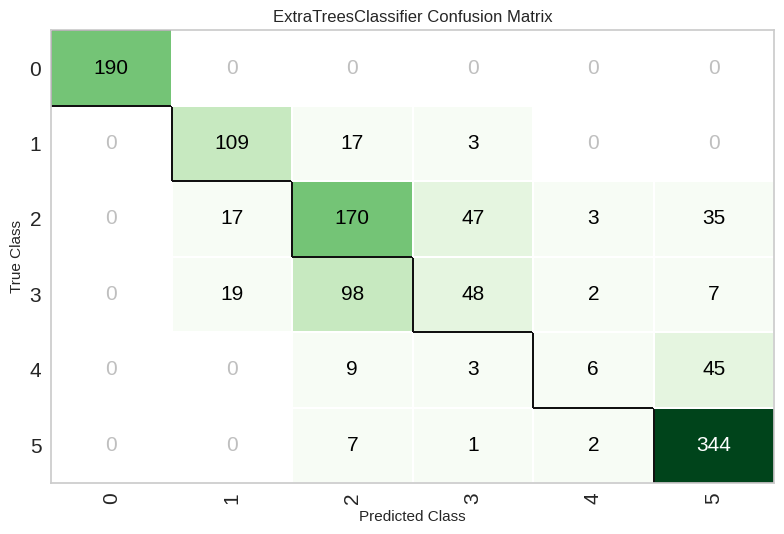

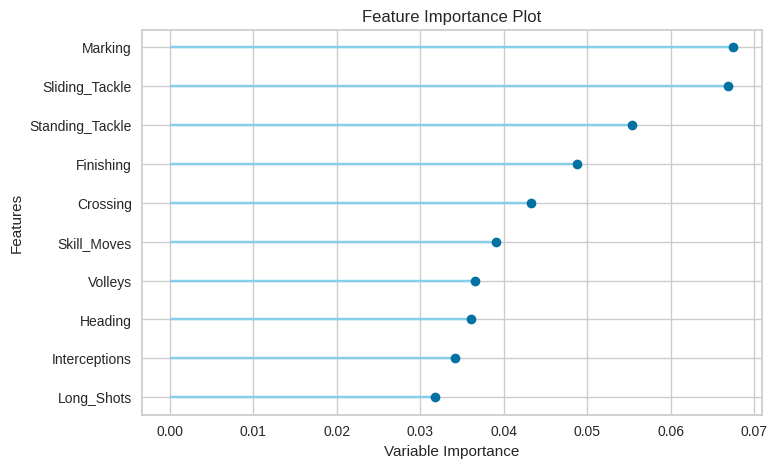

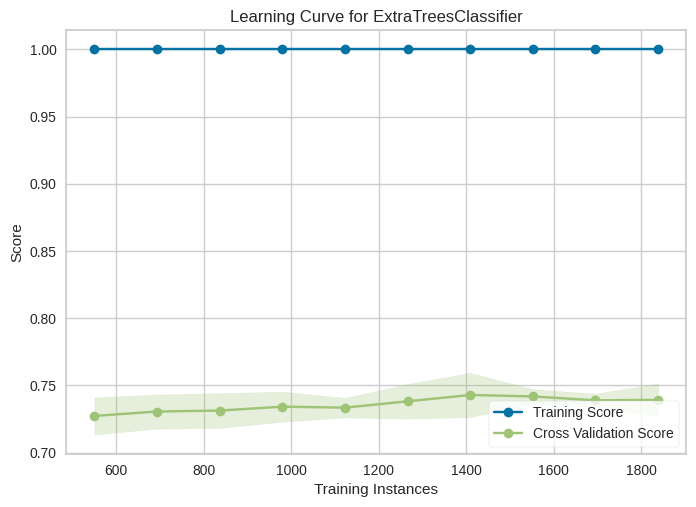

=== Classification report (holdout) ===
                 precision    recall  f1-score   support

        arquero       1.00      1.00      1.00       190
         ataque       0.75      0.84      0.80       129
        central       0.56      0.62      0.59       272
 central_ataque       0.47      0.28      0.35       174
central_defensa       0.46      0.10      0.16        63
        defensa       0.80      0.97      0.88       354

       accuracy                           0.73      1182
      macro avg       0.67      0.64      0.63      1182
   weighted avg       0.71      0.73      0.71      1182


=== Confusion Matrix (holdout) ===
[[190   0   0   0   0   0]
 [  0 109  17   3   0   0]
 [  0  17 170  47   3  35]
 [  0  19  98  48   2   7]
 [  0   0   9   3   6  45]
 [  0   0   7   1   2 344]]
Transformation Pipeline and Model Successfully Saved

Modelo guardado en: (Pipeline(memory=Memory(location=None),
         steps=[('label_encoding',
                 TransformerWrapperWith

In [22]:
from pycaret.classification import evaluate_model, plot_model, predict_model, get_config, save_model
from sklearn.metrics import classification_report, confusion_matrix

# 1) Evaluación interactiva
evaluate_model(best_tree)

# 2) Plots seguros (también en multiclase)
plot_model(best_tree, plot='confusion_matrix')
plot_model(best_tree, plot='feature')
plot_model(best_tree, plot='learning')

# 2b) Plot de threshold SOLO si es binario
y_train_pc = get_config('y_train')
n_classes_train = y_train_pc.nunique() if hasattr(y_train_pc, "nunique") else len(np.unique(y_train_pc))
if n_classes_train == 2:
    plot_model(best_tree, plot='threshold')

# 3) Predicción en holdout y reporte clásico
X_test_pc = get_config('X_test')
y_test_pc = get_config('y_test')

pred_test = predict_model(best_tree, data=X_test_pc)  # respeta el preprocesamiento interno
# Compatibilidad PyCaret v3 (prediction_label) / v2 (Label)
label_col = 'prediction_label' if 'prediction_label' in pred_test.columns else (
    'Label' if 'Label' in pred_test.columns else None
)
if label_col is None:
    raise ValueError(f"No encontré la columna de predicción en predict_model(). "
                     f"Columnas: {list(pred_test.columns)[:25]}")

y_true = np.asarray(y_test_pc)
y_pred = pred_test[label_col].to_numpy()

print("=== Classification report (holdout) ===")
print(classification_report(y_true, y_pred))
print("\n=== Confusion Matrix (holdout) ===")
print(confusion_matrix(y_true, y_pred))

# 4) Ajuste de umbral para reducir falsos positivos (SOLO binario)
classes = np.sort(np.unique(y_true))
if len(classes) == 2:
    pos_label = classes[-1]        # ajusta si tu clase positiva es la otra
    neg_label = classes[0]

    # Probabilidades por clase
    proba_df = predict_model(best_tree, data=X_test_pc, raw_score=True)

    # Columnas de probas = nuevas columnas que no son features ni columnas de predicción
    exclude = set(X_test_pc.columns) | {label_col, 'prediction_score'}
    proba_cols = [c for c in proba_df.columns if c not in exclude]

    # Intenta identificar la columna de probas de la clase positiva
    cand = [c for c in proba_cols
            if str(c).lower() == str(pos_label).lower()
            or str(c).lower().endswith(f"_{str(pos_label).lower()}")]

    if cand:
        scores = proba_df[cand[0]].to_numpy()
        thr = 0.60  # umbral a tu criterio
        y_pred_thr = np.where(scores >= thr, pos_label, neg_label)

        print(f"\n=== Métricas con umbral {thr:.2f} (binario) ===")
        print(classification_report(y_true, y_pred_thr))
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_thr))
    else:
        print("\n[Aviso] No se encontró columna de probabilidad para la clase positiva.")
        print("Revisa las columnas de proba detectadas:", proba_cols[:10])

# 5) Guardar el mejor modelo (incluye todo el pipeline de PyCaret)
SAVE_DIR = "/content/drive/MyDrive/data"
os.makedirs(SAVE_DIR, exist_ok=True)
save_path = save_model(best_tree, f"{SAVE_DIR}/best_tree_pycaret")  # generará un .pkl
print(f"\nModelo guardado en: {save_path}")


**3.2 Reducción de dimensionalidad**

**Pregunta 1:** Inicie entrenando un modelo XGBoost con todas las características disponibles.

In [23]:
from sklearn.metrics import accuracy_score


# Datos
df = data_copy.copy()
X = df.drop(columns=["Club_Position", "label"])
y = df["label"].copy()

# Columnas por tipo
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in ["National_Position", "Preffered_Foot", "Work_Rate"] if c in X.columns]

# Preprocesamiento
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

col_transformer_full = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)],
    verbose_feature_names_out=True
)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, stratify=y, random_state=42
)

# === CORRECCIÓN: encodear y para XGBoost ===
le_y = LabelEncoder()
y_train_enc = le_y.fit_transform(y_train)   # entero 0..K-1
y_test_enc  = le_y.transform(y_test)
n_classes = len(le_y.classes_)
is_binary  = (n_classes == 2)

# XGBoost según #clases
xgb = XGBClassifier(
    objective="binary:logistic" if is_binary else "multi:softprob",
    num_class=None if is_binary else n_classes,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="logloss" if is_binary else "mlogloss"
)

pipeline_xgb_full = Pipeline([
    ("col_transformer", col_transformer_full),
    ("xgb", xgb)
])

# Entrenar (con y encodeado)
pipeline_xgb_full.fit(X_train, y_train_enc)

# Evaluar (pred en enteros y luego volver a texto para el reporte)
y_pred_enc  = pipeline_xgb_full.predict(X_test)
y_pred_txt  = le_y.inverse_transform(y_pred_enc)

print("=== XGBoost (todas las features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_txt))
print(classification_report(y_test, y_pred_txt))

# Guardar para siguientes pasos
X_train_full, X_test_full, y_train_full, y_test_full = X_train, X_test, y_train, y_test

=== XGBoost (todas las features) ===
Accuracy: 0.7309644670050761
                 precision    recall  f1-score   support

        arquero       1.00      1.00      1.00       190
         ataque       0.76      0.82      0.79       129
        central       0.56      0.59      0.57       272
 central_ataque       0.47      0.35      0.40       174
central_defensa       0.36      0.16      0.22        63
        defensa       0.83      0.95      0.88       354

       accuracy                           0.73      1182
      macro avg       0.66      0.65      0.65      1182
   weighted avg       0.71      0.73      0.71      1182



**Pregunta 2:** Una vez el modelo esté entrenado, evalúe y clasifique las características según su importancia de forma descendente.

In [24]:
# Obtener nombres de columnas transformadas
feature_names = pipeline_xgb_full.named_steps["col_transformer"].get_feature_names_out()

# Importancia por features transformadas
importances = pipeline_xgb_full.named_steps["xgb"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

# Agregar importancias por columna original
cat_cols_set = set(cat_cols)
def base_col(name):
    clean = name.split("__", 1)[-1]
    for c in cat_cols_set:
        if clean.startswith(c + "_") or clean == c:
            return c
    return clean

imp_df["base"] = imp_df["feature"].map(base_col)
agg_imp = (imp_df.groupby("base", as_index=False)
                  .agg(total_importance=("importance", "sum"))
                  .sort_values("total_importance", ascending=False)
          )

print("Top 20 features transformadas:\n", imp_df.head(20), "\n")
print("Top 20 columnas base (agregadas):\n", agg_imp.head(20))

# Guardar para el paso 3
imp_df_full = imp_df.copy()
agg_imp_full = agg_imp.copy()


Top 20 features transformadas:
                          feature  importance               base
4               num__Skill_Moves    0.370693        Skill_Moves
8            num__Sliding_Tackle    0.066992     Sliding_Tackle
27                num__Finishing    0.051910          Finishing
7                   num__Marking    0.043927            Marking
15                 num__Crossing    0.021875           Crossing
51    cat__National_Position_RDM    0.021845  National_Position
25                  num__Heading    0.020051            Heading
9           num__Standing_Tackle    0.019382    Standing_Tackle
13                   num__Vision    0.018009             Vision
17                num__Long_Pass    0.016090          Long_Pass
5              num__Ball_Control    0.015429       Ball_Control
6                 num__Dribbling    0.015121          Dribbling
68  cat__Work_Rate_Medium / High    0.014934          Work_Rate
12            num__Interceptions    0.014670      Interceptions
16      

**Pregunta 3:** Utilice esta clasificación para ejecutar una búsqueda recursiva de eliminación de características, eliminando progresivamente las menos importantes y evaluando el impacto en el desempeño del modelo hasta identificar las N características más críticas.

In [25]:
# Eliminación progresiva (RFE manual por ranking)
import time
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder

# --- Prepara/recupera el encoding del target (NUMÉRICO) ---
try:
    le_y_global
    y_train_full_enc
    y_test_full_enc
    n_classes
except NameError:
    le_y_global = LabelEncoder()
    y_train_full_enc = le_y_global.fit_transform(y_train_full)  # usa y_train_full (texto) ya definido
    y_test_full_enc  = le_y_global.transform(y_test_full)
    n_classes = len(le_y_global.classes_)
is_binary = (n_classes == 2)
pos_label_enc = (le_y_global.transform([le_y_global.classes_[-1]])[0] if is_binary else None)

# --- Orden base de features por importancia (asumido existente) ---
ordered_base = agg_imp_full["base"].tolist()

# Rango de K a evaluar
K_list = list(range(min(5, len(ordered_base)), min(len(ordered_base), 40)+1, 5))
results = []

for K in K_list:
    keep_base = set(ordered_base[:K])

    # Filtrar columnas num/cat a conservar
    keep_num = [c for c in num_cols if c in keep_base]
    keep_cat = [c for c in cat_cols if c in keep_base]

    # ColumnTransformer reducido
    num_pipe_k = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ])
    cat_pipe_k = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])

    col_transformer_k = ColumnTransformer(
        [("num", num_pipe_k, keep_num),
         ("cat", cat_pipe_k, keep_cat)],
        verbose_feature_names_out=True
    )

    # Modelo XGB coherente con #clases (usa SIEMPRE y codificado)
    if is_binary:
        xgb_k = XGBClassifier(
            objective="binary:logistic",
            n_estimators=300, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, tree_method="hist", eval_metric="logloss"
        )
        avg_prec = dict(average="binary", pos_label=pos_label_enc)
    else:
        xgb_k = XGBClassifier(
            objective="multi:softprob", num_class=n_classes,
            n_estimators=300, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, tree_method="hist", eval_metric="mlogloss"
        )
        avg_prec = dict(average="macro")

    pipe_k = Pipeline([
        ("col_transformer", col_transformer_k),
        ("xgb", xgb_k)
    ])

    # Entrenar (con y codificado)
    t0 = time.perf_counter()
    pipe_k.fit(X_train_full, y_train_full_enc)
    t1 = time.perf_counter()

    # Predecir (codificado) y métricas
    y_pred_enc = pipe_k.predict(X_test_full)

    acc = accuracy_score(y_test_full_enc, y_pred_enc)
    prec = precision_score(y_test_full_enc, y_pred_enc, **avg_prec, zero_division=0)
    f1   = f1_score(y_test_full_enc, y_pred_enc, average="macro", zero_division=0)
    dur  = t1 - t0

    results.append({
        "K": K,
        "features_kept": K,
        "train_time_s": round(dur, 3),
        "accuracy": round(acc, 4),
        "precision": round(prec, 4),
        "f1_macro": round(f1, 4),
        "keep_num": keep_num,
        "keep_cat": keep_cat
    })

# Tabla de resultados
res_df = pd.DataFrame(results).sort_values(
    ["precision", "accuracy", "train_time_s"],
    ascending=[False, False, True]
).reset_index(drop=True)

print("=== Resultados por K (ordenado por precisión, luego accuracy y tiempo) ===")
display(res_df.head(10))

# Mejor K según criterio
best_row = res_df.iloc[0]
K_best = int(best_row["K"])
keep_num_best = best_row["keep_num"]
keep_cat_best = best_row["keep_cat"]
print(f"\nK* elegido = {K_best}\nNum: {keep_num_best}\nCat: {keep_cat_best}")



=== Resultados por K (ordenado por precisión, luego accuracy y tiempo) ===


,K,features_kept,train_time_s,accuracy,precision,f1_macro,keep_num,keep_cat
0,20,20,1.564,0.7327,0.6722,0.6525,"[Skill_Moves, Ball_Control, Dribbling, Marking...","[National_Position, Preffered_Foot, Work_Rate]"
1,30,30,1.907,0.7327,0.6677,0.6444,"[Height, Weight, Age, Skill_Moves, Ball_Contro...","[National_Position, Preffered_Foot, Work_Rate]"
2,35,35,4.495,0.7411,0.6672,0.6512,"[Height, Weight, Age, Weak_foot, Skill_Moves, ...","[National_Position, Preffered_Foot, Work_Rate]"
3,15,15,1.332,0.7369,0.6654,0.6453,"[Skill_Moves, Ball_Control, Dribbling, Marking...","[National_Position, Preffered_Foot, Work_Rate]"
4,25,25,1.802,0.7318,0.6651,0.6462,"[Height, Skill_Moves, Ball_Control, Dribbling,...","[National_Position, Preffered_Foot, Work_Rate]"
5,10,10,0.956,0.7132,0.6328,0.6183,"[Skill_Moves, Marking, Sliding_Tackle, Standin...","[National_Position, Work_Rate]"
6,5,5,0.772,0.6794,0.5835,0.5717,"[Skill_Moves, Sliding_Tackle, Finishing]","[National_Position, Work_Rate]"



K* elegido = 20
Num: ['Skill_Moves', 'Ball_Control', 'Dribbling', 'Marking', 'Sliding_Tackle', 'Standing_Tackle', 'Interceptions', 'Vision', 'Crossing', 'Short_Pass', 'Long_Pass', 'Speed', 'Strength', 'Heading', 'Finishing', 'Long_Shots', 'Volleys']
Cat: ['National_Position', 'Preffered_Foot', 'Work_Rate']


**Pregunta 4:** Con este conjunto reducido de características, entrene un nuevo modelo y evalúe su rendimiento.

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
import numpy as np

# ========= Asegurar encoding del target =========
try:
    le_y_global
    y_train_full_enc
    y_test_full_enc
    n_classes
except NameError:
    le_y_global = LabelEncoder()
    y_train_full_enc = le_y_global.fit_transform(y_train_full)  # y_train_full en TEXTO -> enteros
    y_test_full_enc  = le_y_global.transform(y_test_full)
    n_classes = len(le_y_global.classes_)

is_binary = (n_classes == 2)
pos_label_text = le_y_global.classes_[-1]         # cambia si tu clase positiva es otra
pos_label_enc  = le_y_global.transform([pos_label_text])[0]

# ========= ColumnTransformer (con las mejores features) =========
num_pipe_best = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])
cat_pipe_best = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

col_transformer_best = ColumnTransformer(
    [("num", num_pipe_best, keep_num_best),
     ("cat", cat_pipe_best, keep_cat_best)],
    verbose_feature_names_out=True
)

# ========= Modelo XGBoost según #clases =========
xgb_best = XGBClassifier(
    objective="binary:logistic" if is_binary else "multi:softprob",
    num_class=None if is_binary else n_classes,
    n_estimators=300, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, tree_method="hist",
    eval_metric="logloss" if is_binary else "mlogloss"
)

pipeline_xgb_reduced = Pipeline([
    ("col_transformer", col_transformer_best),
    ("xgb", xgb_best)
])

# ========= ENTRENAR SIEMPRE CON y ENCODEADO =========
pipeline_xgb_reduced.fit(X_train_full, y_train_full_enc)

# ========= Predicción y reporte (volver a TEXTO para legibilidad) =========
y_pred_red_enc = pipeline_xgb_reduced.predict(X_test_full)
y_pred_red_txt = le_y_global.inverse_transform(y_pred_red_enc)

print("=== XGBoost (conjunto reducido) ===")
print("Accuracy:", accuracy_score(y_test_full, y_pred_red_txt))
print(classification_report(y_test_full, y_pred_red_txt))
print("\n=== Matriz de confusión (reducido) ===")
print(confusion_matrix(y_test_full, y_pred_red_txt))

# ========= Comparación rápida con el modelo completo =========
# Intentamos usar y_pred_full si ya existe; si no, lo recomputamos si existe pipeline_xgb_full
def _ensure_text_preds(y_pred_any):
    """Convierte predicciones a texto si vienen en enteros; si ya son texto, las deja igual."""
    y_pred_any = np.asarray(y_pred_any)
    if y_pred_any.dtype.kind in "iu":  # ints -> a texto con el mismo encoder
        return le_y_global.inverse_transform(y_pred_any)
    return y_pred_any  # ya es texto

y_pred_full_text = None

if "y_pred_full" in globals() or "y_pred_full" in locals():
    try:
        y_pred_full_text = _ensure_text_preds(y_pred_full)
    except Exception:
        y_pred_full_text = None

if y_pred_full_text is None and ("pipeline_xgb_full" in globals() or "pipeline_xgb_full" in locals()):
    try:
        y_pred_full_enc2 = pipeline_xgb_full.predict(X_test_full)
        y_pred_full_text = _ensure_text_preds(y_pred_full_enc2)
    except Exception:
        y_pred_full_text = None

# Cálculo de precisión (macro para multiclase; en binario usa tu positiva explícita)
if y_pred_full_text is not None:
    avg_full = dict(average="macro") if n_classes > 2 else dict(average="binary", pos_label=pos_label_text)
    avg_red  = avg_full

    prec_full = precision_score(y_test_full, y_pred_full_text, **avg_full, zero_division=0)
    prec_red  = precision_score(y_test_full, y_pred_red_txt,  **avg_red,  zero_division=0)

    modo = "macro" if n_classes > 2 else f"binary (pos='{pos_label_text}')"
    print(f"\nPrecisión [{modo}] - Full: {prec_full:.4f} | Reducido: {prec_red:.4f}")
else:
    print("\n[Aviso] No encontré 'y_pred_full' ni 'pipeline_xgb_full' para comparar precisión con el modelo full.")



=== XGBoost (conjunto reducido) ===
Accuracy: 0.7326565143824028
                 precision    recall  f1-score   support

        arquero       1.00      1.00      1.00       190
         ataque       0.78      0.84      0.81       129
        central       0.57      0.58      0.57       272
 central_ataque       0.43      0.34      0.38       174
central_defensa       0.43      0.19      0.26        63
        defensa       0.83      0.95      0.89       354

       accuracy                           0.73      1182
      macro avg       0.67      0.65      0.65      1182
   weighted avg       0.71      0.73      0.72      1182


=== Matriz de confusión (reducido) ===
[[190   0   0   0   0   0]
 [  0 108  14   7   0   0]
 [  0  13 158  65  10  26]
 [  0  18  89  60   3   4]
 [  0   0  10   3  12  38]
 [  0   0   8   5   3 338]]

Precisión [macro] - Full: 0.6626 | Reducido: 0.6722


**Pregunta 5:** Posteriormente, responda a las siguientes preguntas para una comprensión más profunda de los cambios y beneficios:

  - ¿El rendimiento del modelo con las características seleccionadas es similar al del modelo original? ¿Cómo se comparan en términos de precisión y robustez?
  - ¿Cuáles son los beneficios potenciales de eliminar variables del modelo? Considere factores como la simplificación del modelo, reducción del tiempo de entrenamiento, y mejora en la capacidad de generalización.
  - Comente si el modelo con menor dimensionalidad es más sencillo de explicar. Explique brevemente por qué la eliminación de ciertas características puede facilitar la comprensión y la explicación del comportamiento del modelo.

**3.3 Calibración probabilística**

**Pregunta 1:** Se solicita que utilice un método de calibración que asegure que las probabilidades generadas incrementen de manera monótona. Una métrica ampliamente utilizada para evaluar la precisión de la calibración de un modelo es el Brier Score. Calcule el Brier Score para el modelo tanto antes como después de la calibración. Esto le permitirá realizar una comparación cuantitativa y determinar si la calibración ha mejorado el rendimiento del modelo. Para más información sobre el Brier Score, puede consultar el siguiente enlace: [Scikit-Learn - Brier Score Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html).

In [34]:
from copy import deepcopy
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import label_binarize
from sklearn.calibration import CalibratedClassifierCV

## me tira error porque en la varaible dependiente hay categoricas, no numeros discretos.

# Probabilidades del modelo original
proba_orig = pipeline_xgb_full.predict_proba(X_test_full)

classes = np.array(sorted(pd.Series(y_train_full).unique()))
n_classes = len(classes)

def brier_multiclass(y_true, proba, classes):
    """Promedia Brier one-vs-rest por clase (más común en práctica)."""
    Y = label_binarize(y_true, classes=classes)
    if Y.shape[1] == 1 and proba.ndim == 1:
        return brier_score_loss(Y.ravel(), proba.ravel())
    if proba.ndim == 1:
        proba = np.c_[1 - proba, proba]
    scores = []
    for k in range(len(classes)):
        scores.append(brier_score_loss(Y[:, k], proba[:, k]))
    return float(np.mean(scores))

# Brier antes
if n_classes == 2:
    pos_idx = int(np.where(classes == classes.max())[0])
    brier_before = brier_score_loss((y_test_full == classes[pos_idx]).astype(int), proba_orig[:, pos_idx])
else:
    brier_before = brier_multiclass(y_test_full, proba_orig, classes)

print(f"Brier score (ANTES, modelo original): {brier_before:.6f}")

# Construir pipeline calibrado
base_xgb_params = pipeline_xgb_full.named_steps["xgb"].get_params()
base_xgb = XGBClassifier(**base_xgb_params)

pipeline_xgb_calibrated = Pipeline([
    ("col_transformer", deepcopy(col_transformer_full)),
    ("cal", CalibratedClassifierCV(
        estimator=base_xgb,
        method="isotonic",
        cv=5
    ))
])

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_full)
y_test_enc = le.transform(y_test_full)

# Entrenar calibrado en el conjunto de entrenamiento
pipeline_xgb_calibrated.fit(X_train_full, y_train_enc) # acá cambio y_train_full por y_test_enc

# Probabilidades calibradas y Brier después
proba_cal = pipeline_xgb_calibrated.predict_proba(X_test_full)

if n_classes == 2:
    pos_idx = int(np.where(classes == classes.max())[0])
    brier_after = brier_score_loss((y_test_full == classes[pos_idx]).astype(int), proba_cal[:, pos_idx])
else:
    brier_after = brier_multiclass(y_test_full, proba_cal, classes)

print(f"Brier score (DESPUÉS, calibrado isotonic): {brier_after:.6f}")

# tabla resumen
res_brier = pd.DataFrame({
    "modelo": ["original", "calibrado_isotonic"],
    "brier_score": [brier_before, brier_after]
})
print("\nResumen Brier:\n", res_brier)


Brier score (ANTES, modelo original): 0.062915
Brier score (DESPUÉS, calibrado isotonic): 0.058667

Resumen Brier:
                modelo  brier_score
0            original     0.062915
1  calibrado_isotonic     0.058667


**Pregunta 2:** Tras la calibración, examine y comente los resultados obtenidos. A su análisis añada una comparación visual de las ideales versus las salidas del modelo original (sin calibrar) y del modelo calibrado.

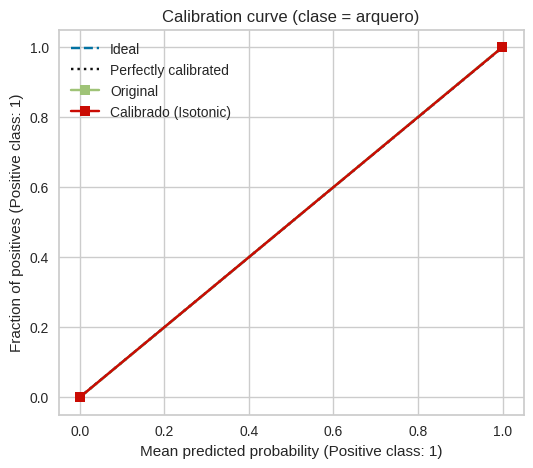

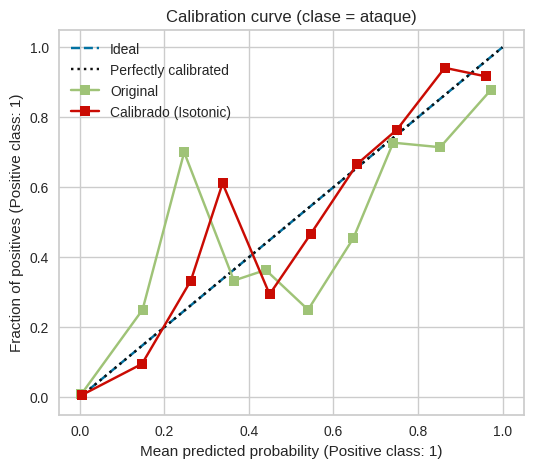

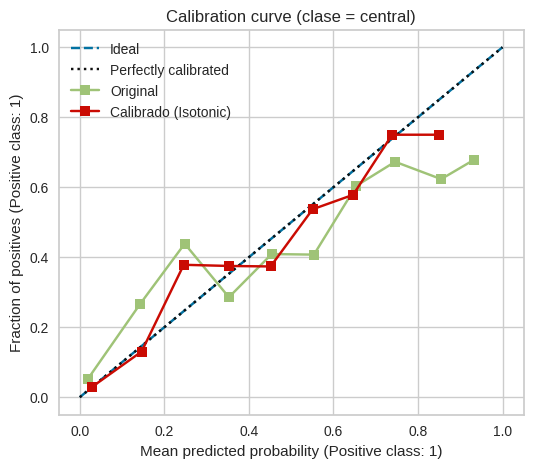

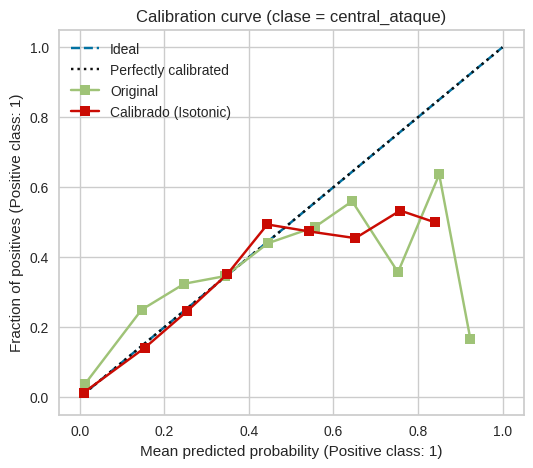

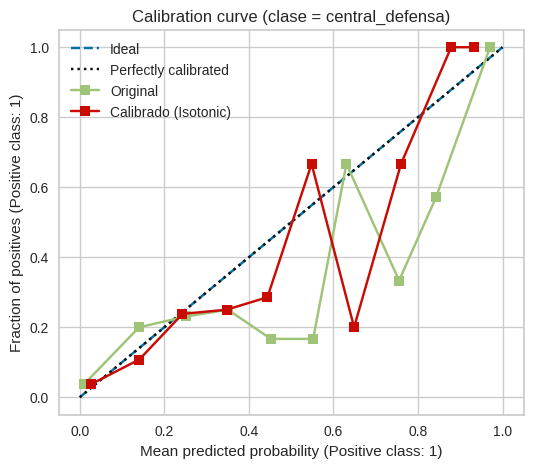

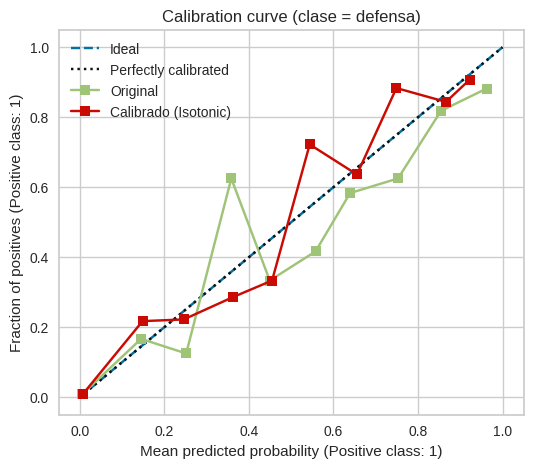

In [35]:
from sklearn.calibration import CalibrationDisplay


classes = np.array(sorted(pd.Series(y_train_full).unique()))
n_classes = len(classes)

def plot_binary_calibration(y_true, proba_orig, proba_cal, pos_label):
    y_bin = (y_true == pos_label).astype(int)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot([0, 1], [0, 1], linestyle="--", label="Ideal")
    CalibrationDisplay.from_predictions(y_bin, proba_orig, n_bins=10, name="Original", ax=ax)
    CalibrationDisplay.from_predictions(y_bin, proba_cal,  n_bins=10, name="Calibrado (Isotonic)", ax=ax)
    ax.set_title(f"Calibration curve (pos_label={pos_label})")
    ax.legend(loc="best")
    plt.show()

def plot_multiclass_calibration(y_true, proba_orig, proba_cal, classes, max_plots=6):
    to_plot = classes[:min(len(classes), max_plots)]
    for c in to_plot:
        y_bin = (y_true == c).astype(int)
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.plot([0, 1], [0, 1], linestyle="--", label="Ideal")
        CalibrationDisplay.from_predictions(y_bin, proba_orig[:, np.where(classes==c)[0][0]],
                                            n_bins=10, name="Original", ax=ax)
        CalibrationDisplay.from_predictions(y_bin, proba_cal[:,  np.where(classes==c)[0][0]],
                                            n_bins=10, name="Calibrado (Isotonic)", ax=ax)
        ax.set_title(f"Calibration curve (clase = {c})")
        ax.legend(loc="best")
        plt.show()

if n_classes == 2:
    pos_label = classes.max()
    plot_binary_calibration(
        y_true=y_test_full,
        proba_orig=proba_orig[:, np.where(classes==pos_label)[0][0]],
        proba_cal= proba_cal[:,  np.where(classes==pos_label)[0][0]],
        pos_label=pos_label
    )
else:
    plot_multiclass_calibration(
        y_true=y_test_full,
        proba_orig=proba_orig,
        proba_cal=proba_cal,
        classes=classes,
        max_plots=6
    )


In [40]:
notebook_name = "Lab5.ipynb"

# Guarda el notebook actual en /content
!jupyter nbconvert --to notebook --execute --inplace --output $notebook_name "/content/drive/MyDrive/Colab Notebooks/$(basename $notebook_name)"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/Lab5.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterAp

In [44]:
# para github:
import nbformat

path = "/content/drive/MyDrive/Colab Notebooks/Copia de Lab5.ipynb"
nb = nbformat.read(path, as_version=4)

# Eliminar metadata conflictiva
if "widgets" in nb["metadata"]:
    del nb["metadata"]["widgets"]

# Guardar limpio
nbformat.write(nb, "lab5_clean.ipynb")